In [2]:
# -*- coding: utf-8 -*-

from itertools import chain, combinations, permutations
import networkx
import matplotlib.pyplot as plt
import numpy as np

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
   

def linked_choices(extra_edges):
    
    choices = []
    remaining = list(range(n))
    
    while remaining != []:
        
        ind = remaining[0]
        link = [ind]
        remaining.remove(ind)
        nextind = (extra_edges[ind]+n-1)%n
        
        while nextind != link[0]:
            
            link.append(nextind)
            ind = nextind
            nextind = (extra_edges[ind]+n-1)%n
            remaining.remove(ind)
        
        choices.append(link)
            
    if len(choices) > 20:
        print("Ended function call to prevent crash")
        return []   
    
    return choices


def find_tours(extra_edges):
    
    choices = linked_choices(extra_edges)
    raw_possible_tours = list(powerset(choices))
    possible_tours = []
    
    for pt in raw_possible_tours:
        l = list(sum(pt, []))
        possible_tours.append(l)
        
    permutations = []
    for pt in possible_tours:
        generated_tour = [(i + 1) % n for i in range(n)]
        for i in pt:
            generated_tour[i] = extra_edges[i]
        permutations.append(generated_tour)
    
    #print(permutations)
    tours = []
    
    for p in permutations:
    
        if set(p) != set(range(n)):
            continue
        subcycle = False
        ind = 0

        for i in range(1, n+1):
            ind = p[ind]
            if ind == 0 and i < n-1:
                subcycle = True
                break
        if not subcycle:
            tours.append(p)
                    
    return tours


def tour_polynomial(extra_edges):
    poly = [0]*(n+1)
    tours = find_tours(extra_edges)
    for t in tours:
        count = 0
        for i in range(n):
            if (t[i] - i + n) % n != 1:
                count += 1
        poly[count] += 1
    poly_str = ""
    for i in range(n+1):
        if poly[i] == 0:
            continue
        elif i == 0:
            poly_str += "1 + "
        elif poly[i] == 1:
            poly_str += "z^" + str(i) + " + "
        else:
            poly_str += str(poly[i])+"z^" + str(i) + " + "
    return poly, poly_str[:-2]

def draw_tours(tours, save = 0):
    c = 1
    for t in tours:
        g = networkx.DiGraph()
        g.add_nodes_from(list(range(n)))
    
        orig_edges = [(i, (i+1)%n) for i in range(n)]
        tour_edges = [(i, t[i]) for i in range(n)]
        tour_edges2 = [(t[i], i) for i in range(n)]
        
        g.add_edges_from(tour_edges)
#         for i in range(n):
#             if t[i] == (i+1)%n:                
#                 g.add_edge(i, (i + n//2 + 1)%n)
#             else:
#                 g.add_edge(i, (i+1)%n)
        
        edge_colors = ['black' if edge in tour_edges or edge in tour_edges2 else 'thistle' for edge in g.edges()]
        
        networkx.draw_circular(g, with_labels=True, edge_color=edge_colors, node_color = "lightgray")
        plt.draw()
        if save:
            plt.savefig("tour"+str(c)+".png", dpi = 100)
        c += 1
        plt.show()
        plt.figure()

def draw_base_tour(extra_edges, save = 0):
    g = networkx.DiGraph()
    g.add_nodes_from(list(range(n)))
    
    orig_edges = [(i, (i+1)%n) for i in range(n)]
    tour_edges = [(i, extra_edges[i]) for i in range(n)]

    g.add_edges_from(orig_edges)    
    g.add_edges_from(tour_edges)
    
    networkx.draw_circular(g, with_labels=True,  node_color = "lightgray")
    plt.draw()
    if save:
        plt.savefig("basetour.png", dpi = 100)
    plt.show()
    plt.figure()


def get_matrix(extra_edges):
    M = []
    for i in range(n):
        l = [0]*n
        l[(i+1)%n] = 1
        l[extra_edges[i]] = 2
        M.append(l)
    return M

def get_edges(matrix):
    extra_edges = list((i + 1) % n for i in range(n))
    for i in range(n):
        for j in range(n):
            if matrix[i][j] == 2:
                extra_edges[i] = j
    return extra_edges

def info_summary(extra_edges):
    poly, poly_str = tour_polynomial(extra_edges)
    tours = find_tours(extra_edges)
    draw_base_tour(extra_edges)
    draw_tours(tours)
    print("The number of tours is:", len(tours))
    print("The polynomial is", poly_str)
    root = np.roots(poly[::-1])
    if root.size > 0:
        print("The root(s) are:", root)
        print("Smallest magnitude among roots is:", min(np.absolute(root)))
    M = get_matrix(extra_edges)
    for i in M:
        print(i)
    return tours
    
def planar(extra_edges):
    g = networkx.DiGraph()
    g.add_nodes_from(list(range(n)))
    
    orig_edges = [(i, (i+1)%n) for i in range(n)]
    tour_edges = [(i, extra_edges[i]) for i in range(n)]

    g.add_edges_from(orig_edges)    
    g.add_edges_from(tour_edges)
    
    planarity, counterex = networkx.algorithms.planarity.check_planarity(g)
    return planarity
    


In [3]:
n = 4
all_perms = list(permutations(list(range(n))))
poly_l = ["1 "]
poly_samp = []
for p in all_perms:
    bad = 0
    for i in range(n):
        if p[i] == (i+1)%n or p[i] == i:
            bad = 1
            break
    if bad:
        continue
    if not planar(p):
        continue
    poly, poly_str = tour_polynomial(p)   
    if poly_str not in poly_l:
        poly_l.append(poly_str)
        root = np.roots(poly[::-1])
        if root.size > 0:
            if min(np.absolute(root)) < 1 - 0.1**5:
                #info_summary(p)
                print(min(np.absolute(root)))
                print(poly_str)
                draw_base_tour(p)
                print()
                print()
                print()
        #print(poly_str)

0.8408964152537141
1 + 2z^4 


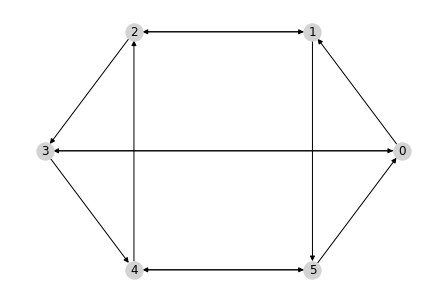




0.7598356856515924
1 + 3z^4 


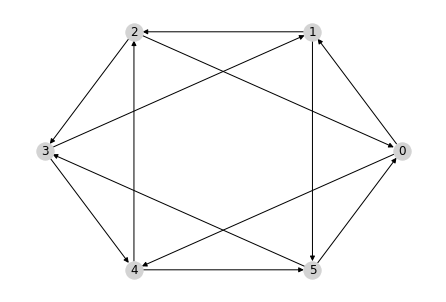

<Figure size 432x288 with 0 Axes>

In [4]:
n = 6
all_perms = list(permutations(list(range(n))))
poly_l = ["1 "]
poly_samp = []
for p in all_perms:
    bad = 0
    for i in range(n):
        if p[i] == (i+1)%n or p[i] == i:
            bad = 1
            break
    if bad:
        continue
    if not planar(p):
        continue
    poly, poly_str = tour_polynomial(p)   
    if poly_str not in poly_l:
        poly_l.append(poly_str)
        root = np.roots(poly[::-1])
        if root.size > 0: #and sum(poly) == 5:
            if min(np.absolute(root)) < 1 - 0.1**5:
                #info_summary(p)
                print(min(np.absolute(root)))
                print(poly_str)
                draw_base_tour(p)
                print()
                print()
                print()
        #print(poly_str)

In [8]:
n = 7
all_perms = list(permutations(list(range(n))))
poly_l = ["1 "]
poly_samp = []
for p in all_perms:
    bad = 0
    for i in range(n):
        if p[i] == (i+1)%n or p[i] == i:
            bad = 1
            break
    if bad:
        continue
    if not planar(p):
        continue
    poly, poly_str = tour_polynomial(p)   
    if poly_str not in poly_l:
        poly_l.append(poly_str)
        root = np.roots(poly[::-1])
        if root.size > 0: #and sum(poly) == 5:
            if min(np.absolute(root)) < 1 - 0.1**5:
                #info_summary(p)
                print(min(np.absolute(root)))
                print(poly_str)
                draw_base_tour(p)
                print()
                print()
                print()
        #print(poly_str)

0.9088626726047159
1 + z^4 + z^6 


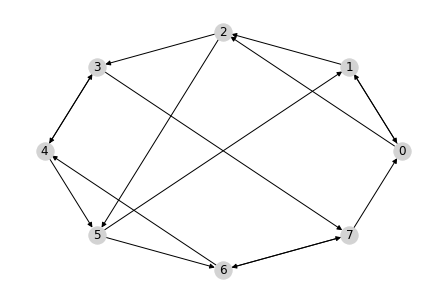




0.8908987181403382
1 + 2z^6 


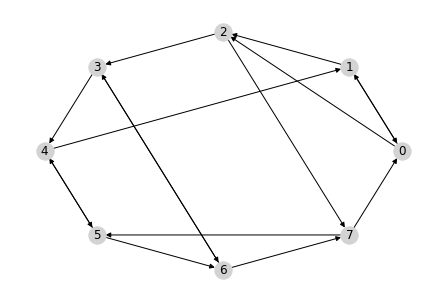




0.7861513777574233
1 + 3z^4 + z^8 


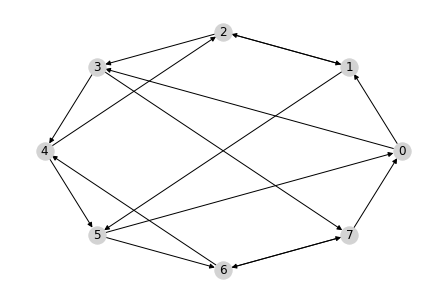




0.7598356856515924
1 + 3z^4 


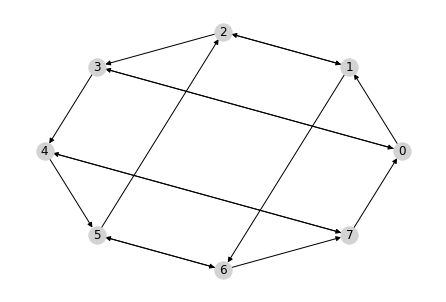




0.7071067811865476
1 + 4z^4 


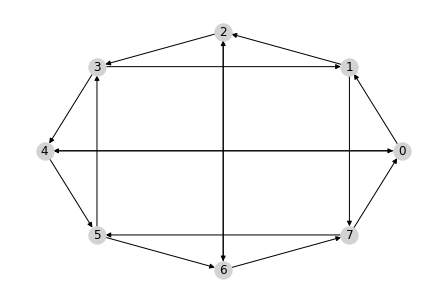

<Figure size 432x288 with 0 Axes>

In [9]:
n = 8
all_perms = list(permutations(list(range(n))))
poly_l = ["1 "]
poly_samp = []
for p in all_perms:
    bad = 0
    for i in range(n):
        if p[i] == (i+1)%n or p[i] == i:
            bad = 1
            break
    if bad:
        continue
    if not planar(p):
        continue
    poly, poly_str = tour_polynomial(p)   
    if poly_str not in poly_l:
        poly_l.append(poly_str)
        root = np.roots(poly[::-1])
        if root.size > 0: #and sum(poly) == 5:
            if min(np.absolute(root)) < 1 - 0.1**5:
                #info_summary(p)
                print(min(np.absolute(root)))
                print(poly_str)
                draw_base_tour(p)
                print()
                print()
                print()
        #print(poly_str)

0.8408964152537138
1 + z^3 + 2z^4 + 2z^7 


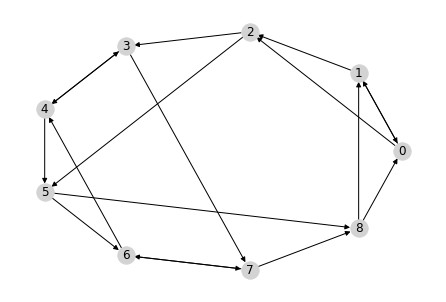




0.886093722644882
1 + z^4 + z^7 


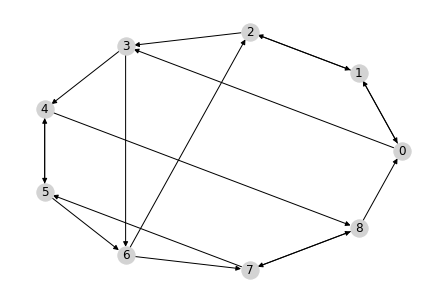




0.9057236642639065
1 + 2z^7 


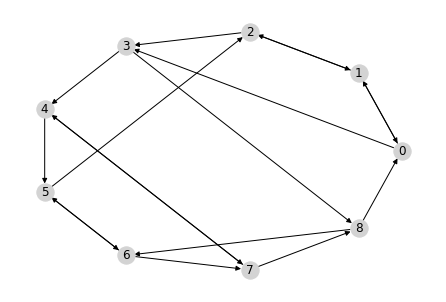




0.9030552240218461
1 + z^5 + z^9 


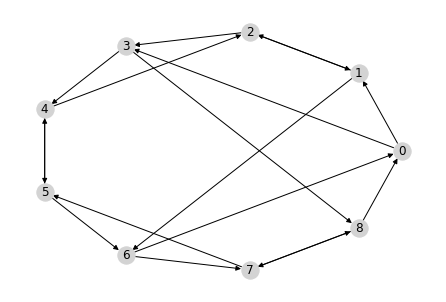




0.8547513999071509
1 + 3z^7 


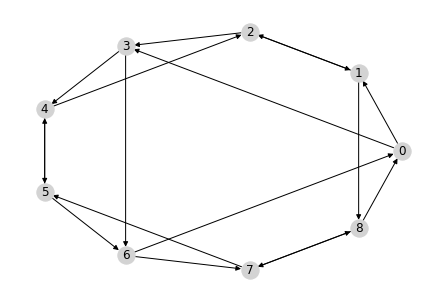




0.8016614323973145
1 + 2z^4 + z^7 


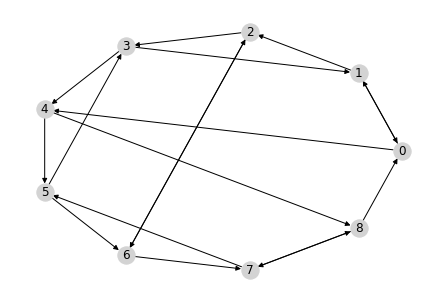




0.8986974519300002
1 + z^4 + z^9 


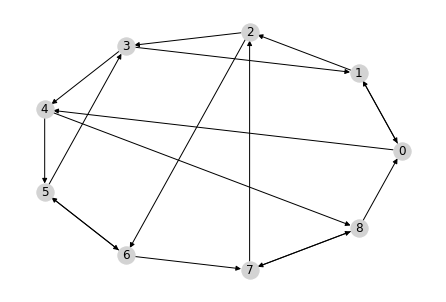




0.8688369618327092
1 + z^4 + z^5 


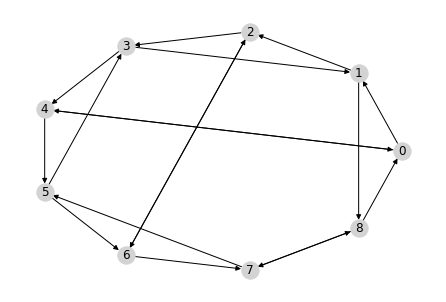

<Figure size 432x288 with 0 Axes>

In [10]:
n = 9
all_perms = list(permutations(list(range(n))))
poly_l = ["1 "]
poly_samp = []
for p in all_perms:
    bad = 0
    for i in range(n):
        if p[i] == (i+1)%n or p[i] == i:
            bad = 1
            break
    if bad:
        continue
    if not planar(p):
        continue
    poly, poly_str = tour_polynomial(p)   
    if poly_str not in poly_l:
        poly_l.append(poly_str)
        root = np.roots(poly[::-1])
        if root.size > 0: #and sum(poly) == 5:
            if min(np.absolute(root)) < 1 - 0.1**5:
                #info_summary(p)
                print(min(np.absolute(root)))
                print(poly_str)
                draw_base_tour(p)
                print()
                print()
                print()
        #print(poly_str)

0.8408964152537141
1 + 2z^4 


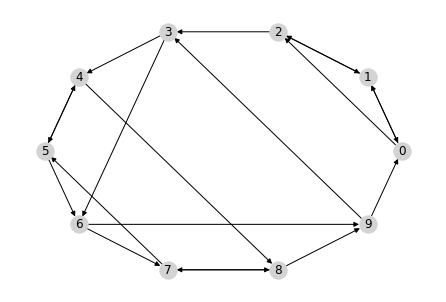




0.917004043204671
1 + 2z^8 


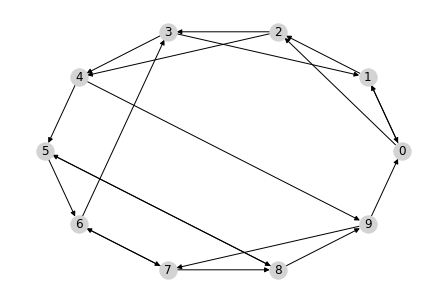




0.8908987181403382
1 + 2z^6 


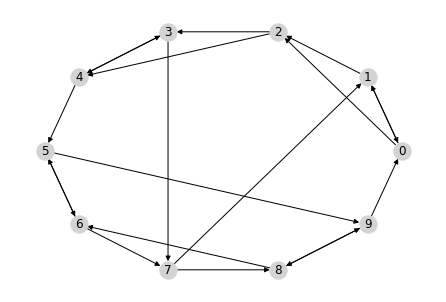




0.9191146117153616
1 + z^6 + z^8 


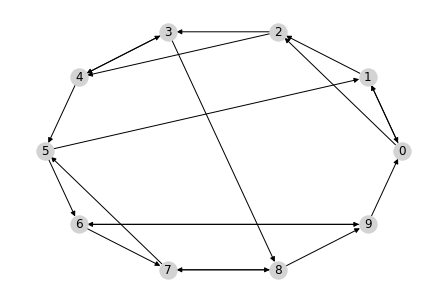




0.8406553621794465
1 + 2z^4 + z^6 + z^10 


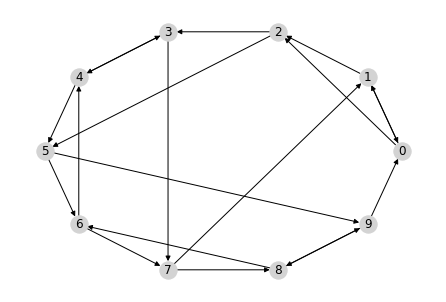




0.8205779005666152
1 + 2z^4 + z^6 


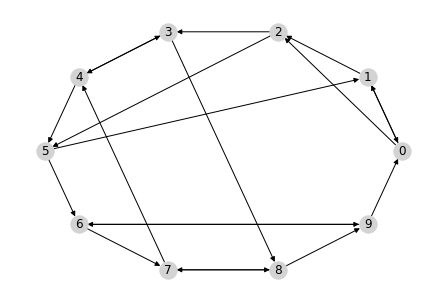




0.873095029609628
1 + z^4 + 2z^6 + z^10 


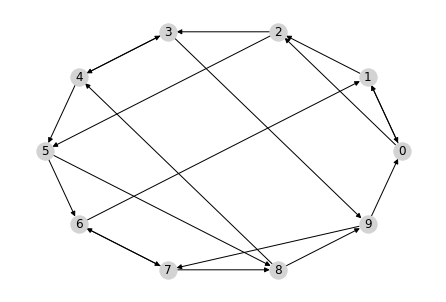




0.7879422827901782
1 + 2z^4 + 2z^6 


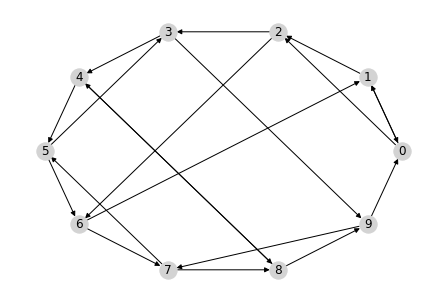




0.832683177655604
1 + 3z^6 


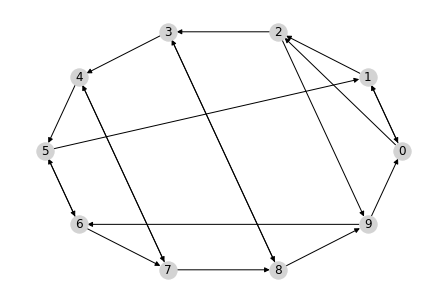




0.9088626726047159
1 + z^4 + z^6 


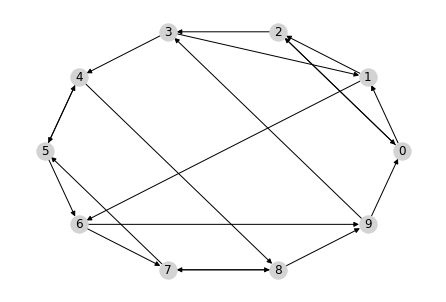




0.8408964152537138
1 + 3z^4 + 2z^8 


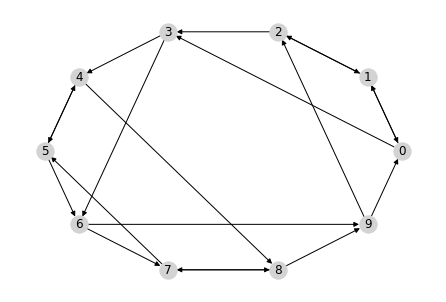




0.7598356856515925
1 + 4z^4 + 3z^8 


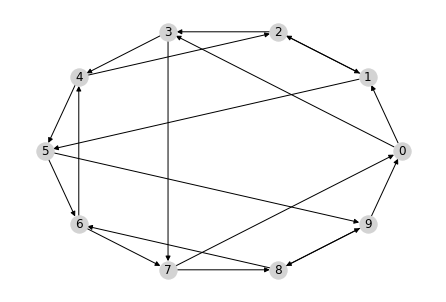




0.7356603157342368
1 + 4z^4 + 2z^8 


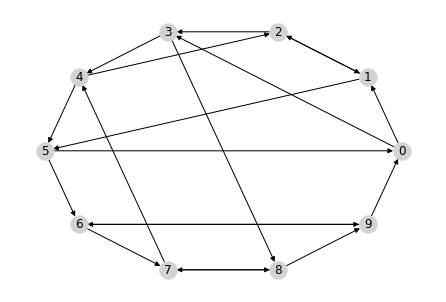




0.684261055783635
1 + 5z^4 + 2z^8 


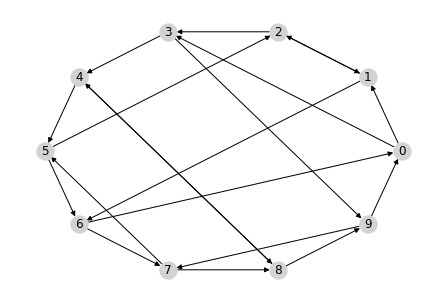




0.7071067811865476
1 + 4z^4 


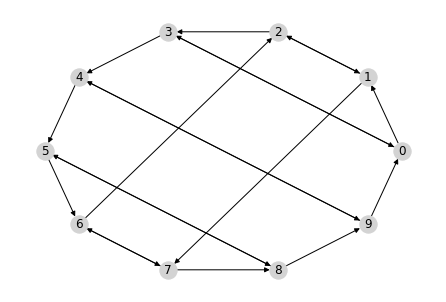




0.9152156985251958
1 + z^6 + z^10 


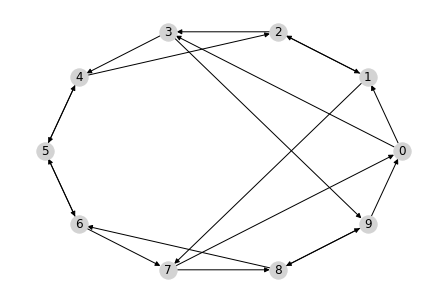




0.9027787989961543
1 + z^6 + z^7 


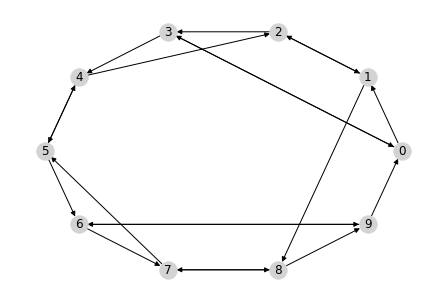




0.9178128349249588
1 + z^4 + z^10 


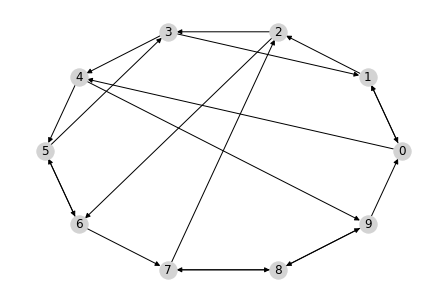




0.9057236642639065
1 + 2z^7 


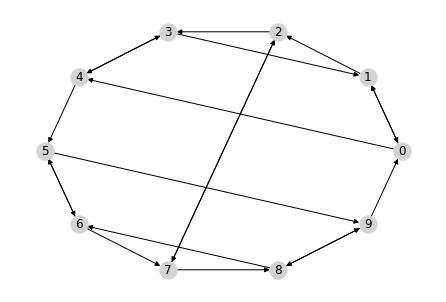




0.8510535583648514
1 + z^6 + 2z^7 


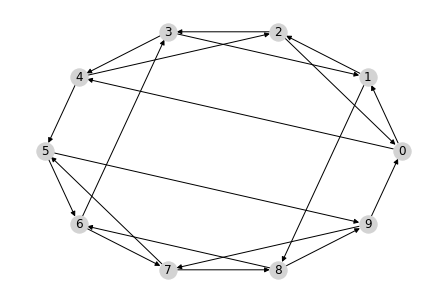




0.638943104246272
1 + 6z^4 


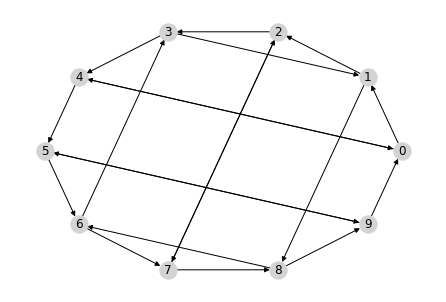




0.8705505632961238
1 + 2z^5 


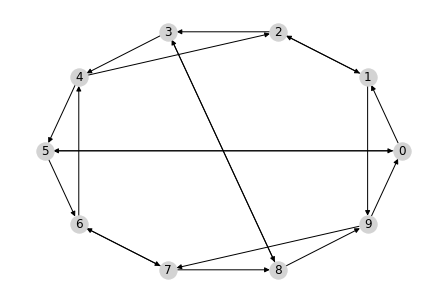

<Figure size 432x288 with 0 Axes>

In [17]:
n = 10
all_perms = list(permutations(list(range(n))))
poly_l = ["1 "]
poly_samp = []
for p in all_perms:
    bad = 0
    for i in range(n):
        if p[i] == (i+1)%n or p[i] == i:
            bad = 1
            break
    if bad:
        continue
    if not planar(p):
        continue
    poly, poly_str = tour_polynomial(p)   
    if poly_str not in poly_l:
        poly_l.append(poly_str)
        root = np.roots(poly[::-1])
        if root.size > 0: #and sum(poly) == 5:
            if min(np.absolute(root)) < 1 - 0.1**5:
                #info_summary(p)
                print(min(np.absolute(root)))
                print(poly_str)
                draw_base_tour(p)
                print()
                print()
                print()
        #print(poly_str)
    



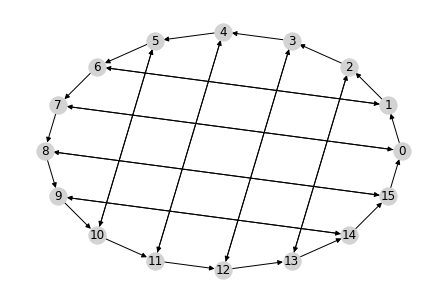

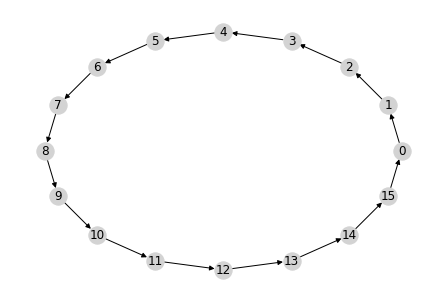

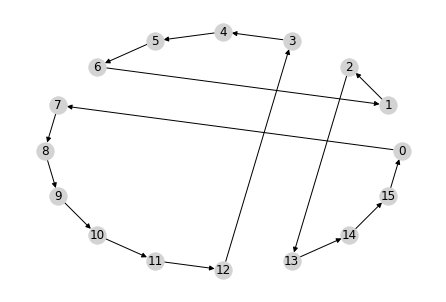

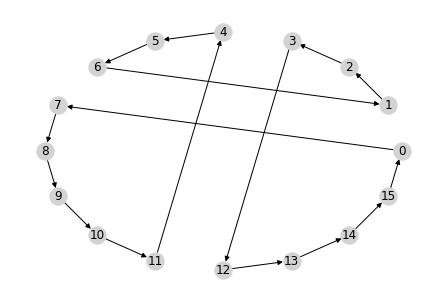

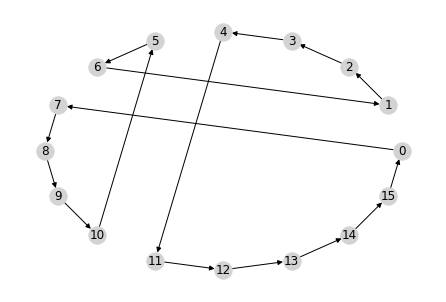

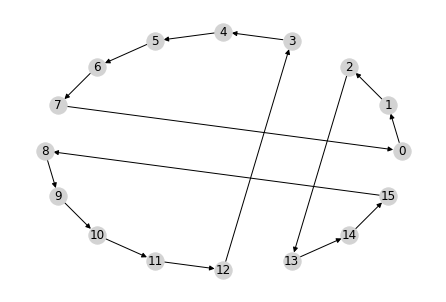

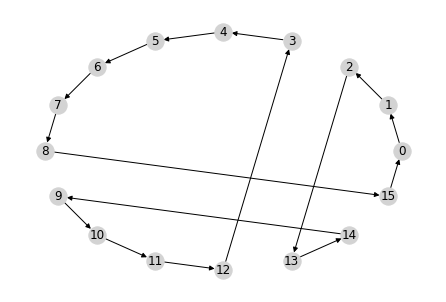

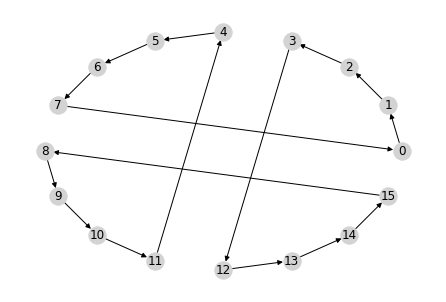

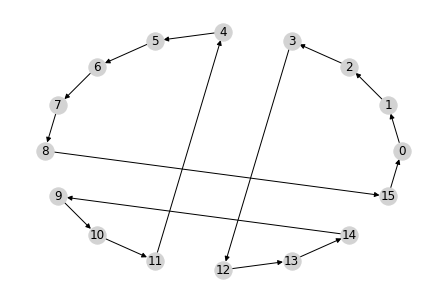

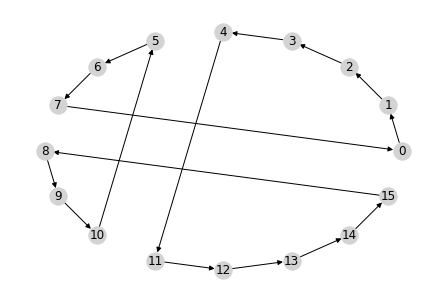

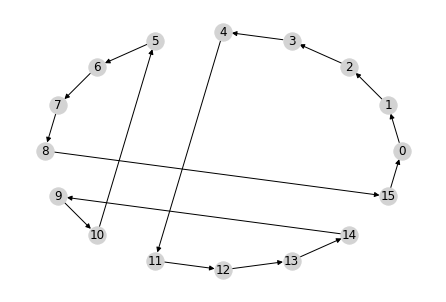

The number of tours is: 10
The polynomial is 1 + 9z^4 
The root(s) are: [-0.40824829+0.40824829j -0.40824829-0.40824829j  0.40824829+0.40824829j
  0.40824829-0.40824829j]
Smallest magnitude among roots is: 0.5773502691896257
[0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0]
[0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0]
[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1]
[1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0],
 [7, 2, 13, 4, 5, 6, 1, 8, 9, 10, 11, 12, 3, 14, 15, 0],
 [7, 2, 3, 12, 5, 6, 1, 8, 9, 10, 11, 4, 13, 14, 15, 0],
 [7, 2, 3, 4, 11, 6, 1, 8, 9, 10, 5, 12, 13, 14, 15, 0],
 [1, 2, 13, 4, 5, 6, 7, 0, 9, 10, 11, 12, 3, 14, 15, 8],
 [1, 2, 13, 4, 5, 6, 7, 8, 15, 10, 11, 12, 3, 14, 9, 0],
 [1, 2, 3, 12, 5, 6, 7, 0, 9, 10, 11, 4, 13, 14, 15, 8],
 [1, 2, 3, 12, 5, 6, 7, 8, 15, 10, 11, 4, 13, 14, 9, 0],
 [1, 2, 3, 4, 11, 6, 7, 0, 9, 10, 5, 12, 13, 14, 15, 8],
 [1, 2, 3, 4, 11, 6, 7, 8, 15, 10, 5, 12, 13, 14, 9, 0]]

<Figure size 432x288 with 0 Axes>

In [14]:
n = 16
extra_edges = [7, 6, 13, 12, 11, 10, 1, 0, 15, 14, 5, 4, 3, 2, 9, 8]
info_summary(extra_edges)


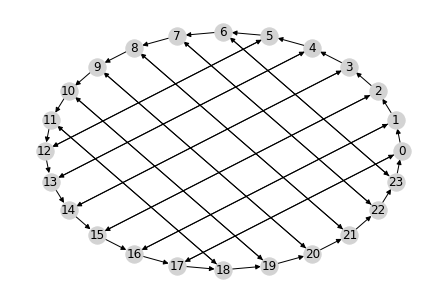

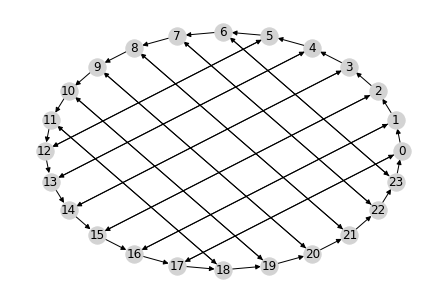

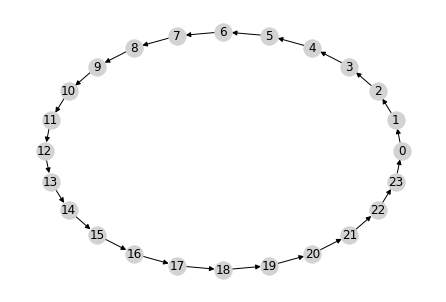

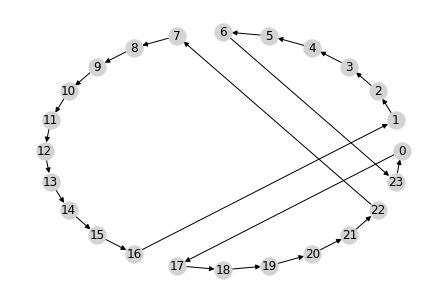

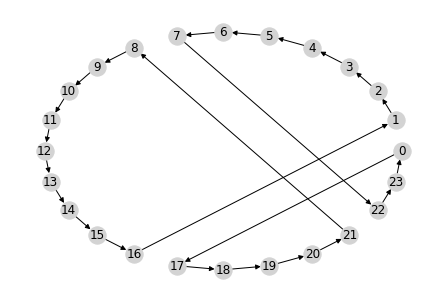

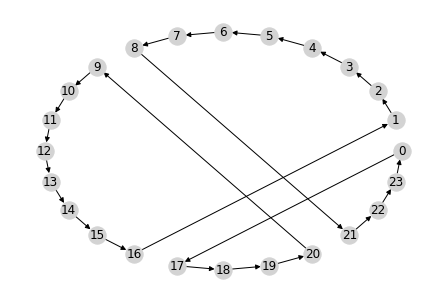

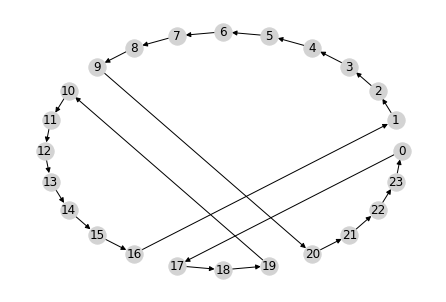

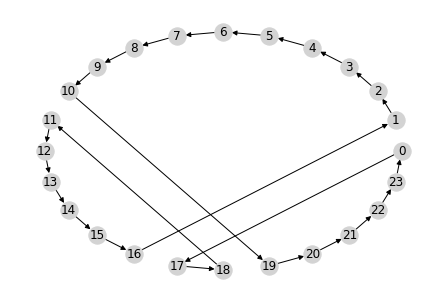

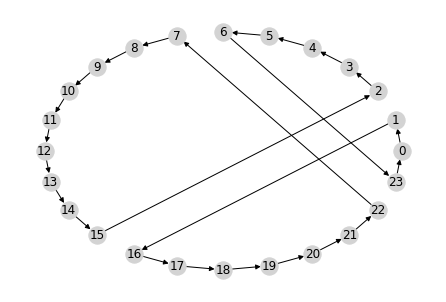

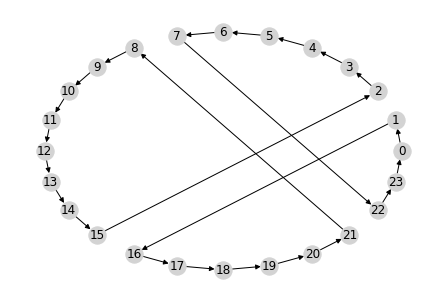

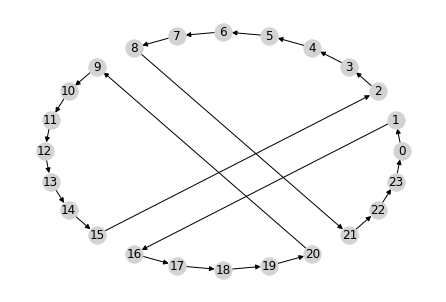

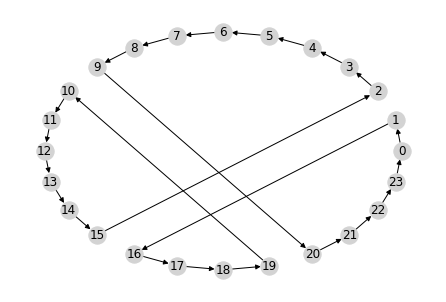

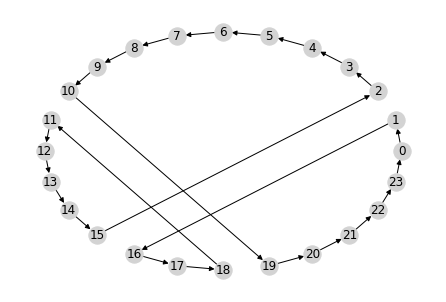

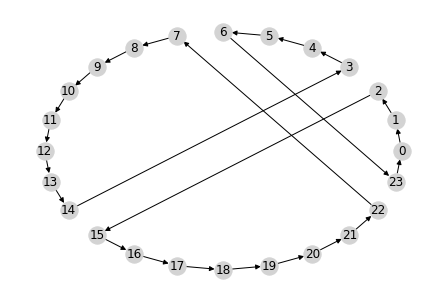

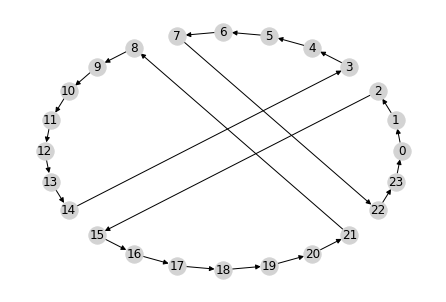

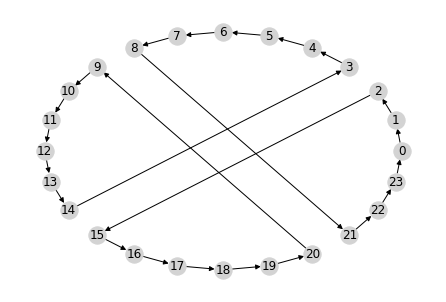

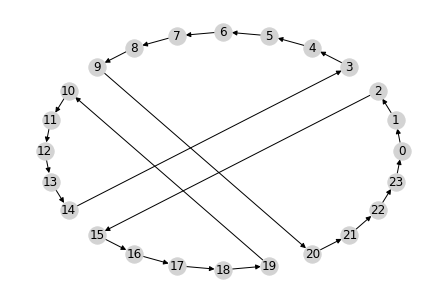

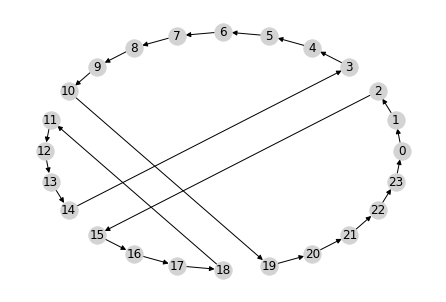

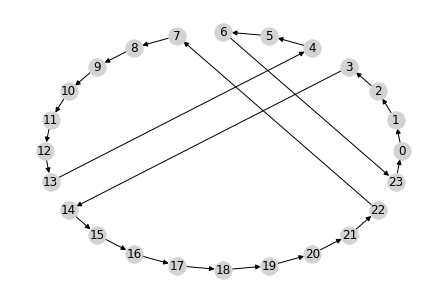

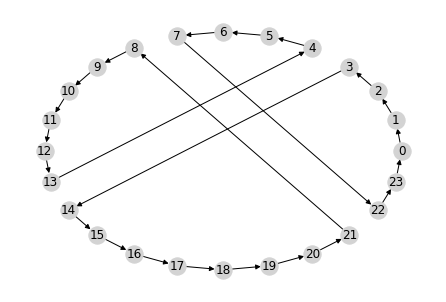

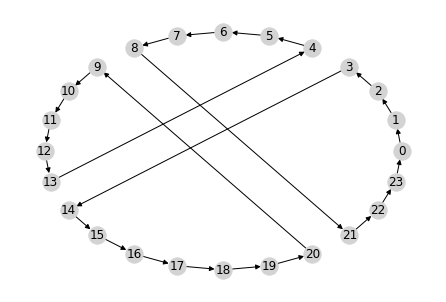

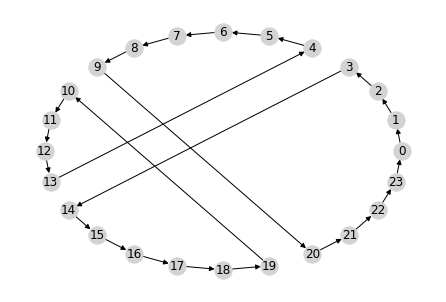

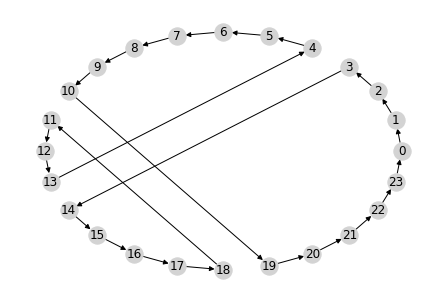

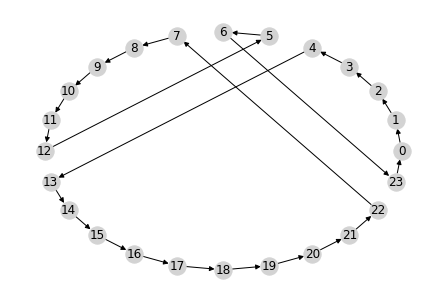

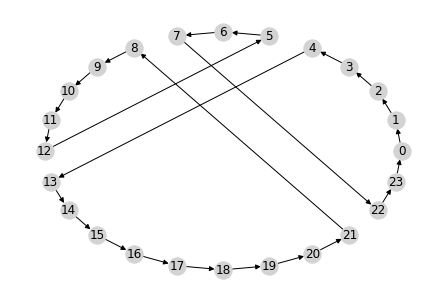

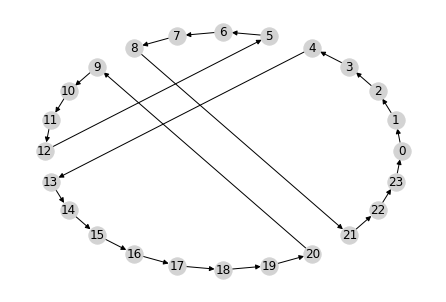

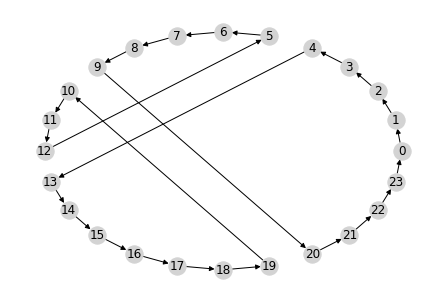

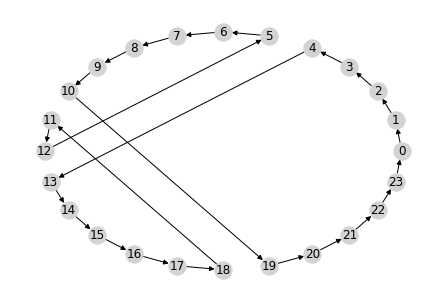

The number of tours is: 26
The polynomial is 1 + 25z^4 
The root(s) are: [-0.31622777+0.31622777j -0.31622777-0.31622777j  0.31622777+0.31622777j
  0.31622777-0.31622777j]
Smallest magnitude among roots is: 0.44721359549995754
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 

[[1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  0],
 [17,
  2,
  3,
  4,
  5,
  6,
  23,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  1,
  18,
  19,
  20,
  21,
  22,
  7,
  0],
 [17,
  2,
  3,
  4,
  5,
  6,
  7,
  22,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  1,
  18,
  19,
  20,
  21,
  8,
  23,
  0],
 [17,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  21,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  1,
  18,
  19,
  20,
  9,
  22,
  23,
  0],
 [17,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  20,
  11,
  12,
  13,
  14,
  15,
  16,
  1,
  18,
  19,
  10,
  21,
  22,
  23,
  0],
 [17,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  19,
  12,
  13,
  14,
  15,
  16,
  1,
  18,
  11,
  20,
  21,
  22,
  23,
  0],
 [1,
  16,
  3,
  4,
  5,
  6,
  23,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  2,
  17,
  18,
  19,
  20,
  21,
  22,
  7,
  0],
 [1,
  16,
  3,
  4,
  5,
  6,
  7,
  22,
  9,
  10,
  

<Figure size 432x288 with 0 Axes>

In [19]:
k = 6
n = 4*k
edges = [0]*n
for i in range(k):
    corres = n - 1 - k - i
    edges[i] = corres
    edges[corres] = i
for i in range(k, 2*k):
    corres = n - 1 + k - i
    edges[i] = corres
    edges[corres] = i
draw_base_tour(edges)
info_summary(edges)